In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from utils.fehler_gauss import fehler_gauss, weighted_mean
from sympy import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Linsentypen

- A Sammellinse
- B Sammellinse
- G Sammellinse
- E Streulinse

## Allgemeine Settings

In [2]:
pos_lampe = 0e-2
u_pos_lampe = 0.1e-2

pos_linse_a = 5e-2
u_pos_linse_a = 0.1e-2

pos_gitter = 20e-2
u_pos_gitter = 0.1e-2

## Autokollimationsmethode Einfachlinsen

Brennweite: $f' = \frac{k + l -h}{2} \approx \frac{k + l}{2}$

In [3]:
d_linse_spiegel = 3e-2
u_d_linse_spiegel = 0.1e-2

autokoll_einfach = pd.read_excel("OPA.xlsx", sheet_name="AutokollimationEinfachlinsen") * 1e-2 # importieren in meter
u_autokoll_einfach = 0.3e-2 # ableseunsicherheit in meter

k = autokoll_einfach - pos_gitter # abstand gitter - bildschirm
l = k # abstand gitter - bildschirm umgedreht (nutzen einfach das Gleiche weil Gangsta)

In [4]:
# Typ A Unsicherheiten für die Abstände (korrigiert mit Student-t Verteilung)
u_k_typ_a = k.std(ddof=1) * 0.51
u_l_typ_a = l.std(ddof=1) * 0.51

# Gaussche Fehlerfortpflanzung für die Brennweite
k_symbol, l_symbol = symbols("k l")
brennweite_formula = (k_symbol + l_symbol) / 2
brennweite_formula

k/2 + l/2

In [5]:
gesamtunsicherheit_k = np.sqrt(u_k_typ_a**2 + u_autokoll_einfach**2)
gesamtunsicherheit_l = np.sqrt(u_l_typ_a**2 + u_autokoll_einfach**2)

brennweite, u_brennweite = fehler_gauss(
    brennweite_formula,
    [k_symbol, l_symbol],
    [k.mean(), l.mean()],
    [gesamtunsicherheit_k, gesamtunsicherheit_l],
)
brennweite * 1e2 # brennweite in cm

G     7.50
B    10.18
dtype: float64

In [6]:
u_brennweite * 1e2 # unsicherheit in cm

G    0.215176
B    0.214267
dtype: float64

## Besselmethode Einfachlinsen

$e = -a_1 + h + d + a_2' = -a_2 + h - d + a_1' = b_k - g_k$

$b_k$ Position Schirm beim kleinen Bild

$g$ Position Gitter

$d = l_k - l_g$ Abstand zwischen den rechten Hauptebenen von kleinem zu großem Bild

$l_k$ Position der Linse beim kleinen Bild

$l_g$ Position der Linse beim großen Bild

Brennweite $f' = \frac{1}{4} \cdot \left[(e - h) - \frac{d^2}{e - h} \right] \approx \frac{1}{4} \cdot \left[e - \frac{d^2}{e}\right]$ (dünne Linse)

In [7]:
gittergroesse = 5e-3
u_gittergroesse = 0.1e-2

gittergroesse_schirm = 20e-3
u_gittergroesse_schirm = 0.1e-3

g_pos_schirm = 69.5e-2
u_g_pos_schirm = 0.1e-2

e_pos_schirm = 84.1e-2
u_e_pos_schirm = 0.1e-2

bessel_einfach = pd.read_excel("OPA.xlsx", sheet_name="BesselEinfachlinsen") * 1e-2 # in meter
bessel_einfach

,G gross,G klein,E gross,E klein
0,0.294,0.611,0.329,0.720
1,0.294,0.609,0.325,0.719
2,0.291,0.608,0.329,0.720
3,0.292,0.606,0.327,0.722
4,0.293,0.608,0.325,0.720


In [8]:
# gausssche Fehlerfortpflanzung für die Brennweite
b_k_symbol, g_symbol = symbols("b_k g")
e = b_k_symbol - g_symbol

l_k_symbol, l_g_symbol = symbols("l_k l_g")
d = l_k_symbol - l_g_symbol

brennweite_formula = 1/4 * (e - d**2/e)
brennweite_formula

0.25*b_k - 0.25*g - 0.25*(-l_g + l_k)**2/(b_k - g)

In [9]:
# Bessel für Linse G
brennweiten_g, u_brennweiten_g = fehler_gauss(
    brennweite_formula,
    [b_k_symbol, g_symbol, l_k_symbol, l_g_symbol],
    [
        g_pos_schirm,
        pos_gitter,
        bessel_einfach["G klein"],
        bessel_einfach["G gross"],
    ],
    [u_g_pos_schirm, u_pos_gitter, 5e-3, 5e-3],
)
brennweite_g, u_brennweite_g = weighted_mean(brennweiten_g, u_brennweiten_g)
brennweite_g * 1e2, u_brennweite_g * 1e2 # Ergebnisse in cm

(np.float64(7.34473964091435), np.float64(0.10323126960090592))

In [10]:
# Bessel für Linse E
brennweiten_e, u_brennweiten_e = fehler_gauss(
    brennweite_formula,
    [b_k_symbol, g_symbol, l_k_symbol, l_g_symbol],
    [
        e_pos_schirm,
        pos_gitter,
        bessel_einfach["E klein"],
        bessel_einfach["E gross"],
    ],
    [u_e_pos_schirm, u_pos_gitter, 5e-3, 5e-3],
)
brennweite_e, u_brennweite_e = weighted_mean(brennweiten_e, u_brennweiten_e)
brennweite_e * 1e2, u_brennweite_e * 1e2 # Ergebnisse in cm

(np.float64(9.995497858863873), np.float64(0.0993978008322837))

## Brennweite und Hauptebenenabstand Linsensystem mit Kombination aus Autokollimation und Bessel

$f' = \frac{1}{2} \sqrt{(e - k - l)^2 - d^2}$

$h = k + l - \sqrt{(e - k - l)^2 - d^2}$

In [11]:
autokoll_linsensystem = pd.read_excel("OPA.xlsx", sheet_name="AutokollimationLinsensystem") * 1e-2 # in meter
autokoll_linsensystem

,G-E-Spiegel,E-G-Spiegel
0,0.366,0.308
1,0.365,0.306
2,0.367,0.308
3,0.366,0.305
4,0.367,0.306


In [12]:
g_e_pos_schirm = 107.5e-2
u_g_e_pos_schirm = 0.1e-2

e_g_pos_schirm = 104.6e-2
u_e_g_pos_schirm = 0.1e-2

bessel_linsensystem = pd.read_excel("OPA.xlsx", sheet_name="BesselLinsensystem") * 1e-2 # in meter
bessel_linsensystem

,G-E-gross,G-E-klein,E-G-gross,E-G-klein
0,0.392,0.941,0.339,0.847
1,0.391,0.944,0.342,0.848
2,0.393,0.940,0.342,0.851
3,0.394,0.940,0.337,0.851
4,0.394,0.944,0.341,0.850


In [13]:
# fehler gauss
e_symbol, d_symbol, k_symbol, l_symbol = symbols("e d k l")
brennweite_formula = 1/2 * sqrt((e_symbol - k_symbol - l_symbol)**2 - d_symbol**2)
brennweite_formula

0.5*sqrt(-d**2 + (e - k - l)**2)

In [14]:
h_formula = k_symbol + l_symbol - sqrt((e_symbol - k_symbol - l_symbol)**2 - d_symbol**2)
h_formula

k + l - sqrt(-d**2 + (e - k - l)**2)

In [15]:
k = autokoll_linsensystem["E-G-Spiegel"] - pos_gitter
u_k = np.sqrt((k.std(ddof=1) * 0.51)**2 + 5e-3**2 + 1e-3**2) # Unsicherheit k mit Typ A und Ableseunsicherheit
k = k.mean()

l = autokoll_linsensystem["G-E-Spiegel"] - pos_gitter
u_l = np.sqrt((l.std(ddof=1) * 0.51)**2 + 5e-3**2 + 1e-3**2) # Unsicherheit l mit Typ A und Ableseunsicherheit
l = l.mean()

brennweiten = []
u_brennweiten = []

hs = []
u_hs = []

for order, pos_schirm, u_pos_schirm in [
   ("G-E", g_e_pos_schirm, u_g_e_pos_schirm),
   ("E-G", e_g_pos_schirm, u_e_g_pos_schirm)
]:
    e = pos_schirm - pos_gitter
    u_e = np.sqrt(u_pos_schirm**2 + u_pos_gitter**2)
    d = bessel_linsensystem[f"{order}-klein"] - bessel_linsensystem[f"{order}-gross"]
    u_d = np.sqrt((5e-3)**2 + (5e-3)**2 + d.std(ddof=1)**2 * 0.51**2)
    d = d.mean()

    brennweite, u_brennweite = fehler_gauss(
        brennweite_formula,
        [e_symbol, d_symbol, k_symbol, l_symbol],
        [e, d, k, l],
        [u_e, u_d, u_k, u_l],
    )
    print(f"{order}-Schirm: {brennweite * 1e2, u_brennweite * 1e2}")
    brennweiten.append(brennweite)
    u_brennweiten.append(u_brennweite)

    h, u_h = fehler_gauss(
        h_formula,
        [e_symbol, d_symbol, k_symbol, l_symbol],
        [e, d, k, l],
        [u_e, u_d, u_k, u_l],
    )
    print(f"{order}-Schirm: {h * 1e2, u_h * 1e2}")
    hs.append(h)
    u_hs.append(u_h)

# Gewichteter Mittelwert Brennweite
brennweite, u_brennweite = weighted_mean(np.array(brennweiten), np.array(u_brennweiten))
print(f"Gewichteter Mittelwert Brennweite: {brennweite * 1e2, u_brennweite * 1e2}")

# Gewichteter Mittelwert h
h, u_h = weighted_mean(np.array(hs), np.array(u_hs))
print(f"Gewichteter Mittelwert h: {h * 1e2, u_h * 1e2}")

G-E-Schirm: (np.float64(12.373746401151102), np.float64(1.2034000719578621))
G-E-Schirm: (np.float64(2.5325071976978), np.float64(2.980192685121881))
E-G-Schirm: (np.float64(13.15993920958604), np.float64(1.066320908081793))
E-G-Schirm: (np.float64(0.9601215808279218), np.float64(2.7143913978521583))
Gewichteter Mittelwert Brennweite: (np.float64(12.814152138335563), np.float64(0.7980863359707846))
Gewichteter Mittelwert h: (np.float64(1.6730810259047706), np.float64(2.006768274482417))


## Aufgabe 7 (Brennweite der Zerstreuungslinse des Systems aus Kombimethode)

In [16]:
f1p_symbol, f2p_symbol, fp_symbol, t_symbol = symbols("f_1' f_2' f' t")
Delta = t_symbol - f1p_symbol - f2p_symbol
Delta

-f_1' - f_2' + t

In [17]:
gleichung6 = Eq(fp_symbol, (f1p_symbol * f2p_symbol)/Delta)
gleichung6

Eq(f', f_1'*f_2'/(-f_1' - f_2' + t))

In [18]:
f2p_formula = solve(gleichung6, f2p_symbol)[0]
f2p_formula = (fp_symbol * (t_symbol - f1p_symbol)) / (fp_symbol - f1p_symbol)
f2p_formula

f'*(-f_1' + t)/(f' - f_1')

In [19]:
f2p, u_f2p = fehler_gauss(
    f2p_formula,
    [fp_symbol, f1p_symbol, t_symbol],
    [brennweite, brennweite_g, 3e-2],
    [u_brennweite, u_brennweite_g, 0.1e-2],
)
f2p * 1e2, u_f2p * 1e2

(np.float64(-10.179183739822848), np.float64(0.9838853565242299))

## Abbeverfahren Linsensysteme

In [43]:
dfs = {
    "e-g-schirm": pd.read_excel("OPA.xlsx", sheet_name="AbbeE-G-Schirm"),
    "g-e-schirm": pd.read_excel("OPA.xlsx", sheet_name="AbbeG-E-Schirm"),
}

for key, df in dfs.items():
    df["Vergroesserung"] = df["Vergroesserung"] * -1e-3
    df["Verkleinerung"] = df["Verkleinerung"] * -1e-3
    df["Schirm"] = df["Schirm"] * 1e-2
    df["Position G"] = df["Position G"] * 1e-2
    df["Position G.1"] = df["Position G.1"] * 1e-2
    df["g_Vergroesserung"] = -(df["Position G"] - pos_gitter)
    df["g_Verkleinerung"] = -(df["Position G.1"] - pos_gitter)
    df["g'_Vergroesserung"] = df["Schirm"] - df["Position G"]
    df["g'_Verkleinerung"] = df["Schirm"] - df["Position G.1"]

dfs["e-g-schirm"]

,Schirm,Vergroesserung,Position G,Verkleinerung,Position G.1,g_Vergroesserung,g_Verkleinerung,g'_Vergroesserung,g'_Verkleinerung
0,1.50,-0.03440,0.330,-0.00100,1.321,-0.130,-1.121,1.170,0.179
1,1.25,-0.02455,0.327,-0.00100,1.061,-0.127,-0.861,0.923,0.189
2,1.00,-0.01760,0.334,-0.00135,0.799,-0.134,-0.599,0.666,0.201
3,0.75,-0.00765,0.380,-0.00320,0.521,-0.180,-0.321,0.370,0.229


In [44]:
groesse_gitter = 5e-3
u_groesse_gitter = 0.1e-3

In [45]:
# Vergrößerungen / Verkleinerungen mit Unsicherheiten bestimmen
y_symbol, yp_symbol = symbols("y y'")
beta = yp_symbol / y_symbol
beta

y'/y

In [46]:
for category in ["Vergroesserung", "Verkleinerung"]:
    for df in dfs.values():
        beta_verkleinerung, u_beta_verkleinerung = fehler_gauss(
            beta,
            [y_symbol, yp_symbol],
            [groesse_gitter, df[category]],
            [u_groesse_gitter, 1e-3],
        )
        df[f"beta_{category}"] = beta_verkleinerung
        df[f"u_beta_{category}"] = u_beta_verkleinerung

dfs["e-g-schirm"]

,Schirm,Vergroesserung,Position G,Verkleinerung,Position G.1,g_Vergroesserung,g_Verkleinerung,g'_Vergroesserung,g'_Verkleinerung,beta_Vergroesserung,u_beta_Vergroesserung,beta_Verkleinerung,u_beta_Verkleinerung
0,1.50,-0.03440,0.330,-0.00100,1.321,-0.130,-1.121,1.170,0.179,-6.88,0.242763,-0.20,0.200040
1,1.25,-0.02455,0.327,-0.00100,1.061,-0.127,-0.861,0.923,0.189,-4.91,0.222808,-0.20,0.200040
2,1.00,-0.01760,0.334,-0.00135,0.799,-0.134,-0.599,0.666,0.201,-3.52,0.212029,-0.27,0.200073
3,0.75,-0.00765,0.380,-0.00320,0.521,-0.180,-0.321,0.370,0.229,-1.53,0.202327,-0.64,0.200409


In [47]:
betas = {"e-g": None, "g-e": None}

# for order in betas.keys():
#     betas[order] = pd.DataFrame({
#         "beta": pd.concat((dfs[f"{order}-schirm"]["beta_Vergroesserung"], dfs[f"{order}-schirm"]["beta_Verkleinerung"])),
#         "u_beta": pd.concat((dfs[f"{order}-schirm"]["u_beta_Vergroesserung"], dfs[f"{order}-schirm"]["u_beta_Verkleinerung"])),
#         "Schirm": pd.concat((dfs[f"{order}-schirm"]["Schirm"], dfs[f"{order}-schirm"]["Schirm"])),
#         "g": pd.concat((dfs[f"{order}-schirm"]["g_Vergroesserung"], dfs[f"{order}-schirm"]["g_Verkleinerung"])),
#         "g'": pd.concat((dfs[f"{order}-schirm"]["g'_Vergroesserung"], dfs[f"{order}-schirm"]["g'_Verkleinerung"])),
#     })

for order in betas.keys():
    betas[order] = pd.DataFrame(
        {
            "beta": dfs[f"{order}-schirm"]["beta_Vergroesserung"],
            "u_beta": dfs[f"{order}-schirm"]["u_beta_Vergroesserung"],
            "Schirm": dfs[f"{order}-schirm"]["Schirm"],
            "g": dfs[f"{order}-schirm"]["g_Vergroesserung"],
            "g'": dfs[f"{order}-schirm"]["g'_Vergroesserung"],
        }
    )

betas["e-g"]

,beta,u_beta,Schirm,g,g'
0,-6.88,0.242763,1.50,-0.130,1.170
1,-4.91,0.222808,1.25,-0.127,0.923
2,-3.52,0.212029,1.00,-0.134,0.666
3,-1.53,0.202327,0.75,-0.180,0.370


In [48]:
# 1 - 1/beta berechnen mit Unsicherheiten
beta_symbol = symbols("beta")
regression1_formula = 1 - 1/beta_symbol
regression1_formula

1 - 1/beta

In [49]:
regression2_formula = 1 - beta_symbol
regression2_formula

1 - beta

In [50]:
for key, df in betas.items():
    for regression_formula, name in [
        (regression1_formula, "1-1/beta"),
        (regression2_formula, "1-beta"),
    ]:
        regression, u_regression = fehler_gauss(
            regression_formula,
            [beta_symbol],
            [df["beta"]],
            [df["u_beta"]],
        )
        df[name] = regression
        df[f"u_{name}"] = u_regression

betas["e-g"]

,beta,u_beta,Schirm,g,g',1-1/beta,u_1-1/beta,1-beta,u_1-beta
0,-6.88,0.242763,1.50,-0.130,1.170,1.145349,0.005129,7.88,0.242763
1,-4.91,0.222808,1.25,-0.127,0.923,1.203666,0.009242,5.91,0.222808
2,-3.52,0.212029,1.00,-0.134,0.666,1.284091,0.017112,4.52,0.212029
3,-1.53,0.202327,0.75,-0.180,0.370,1.653595,0.086431,2.53,0.202327


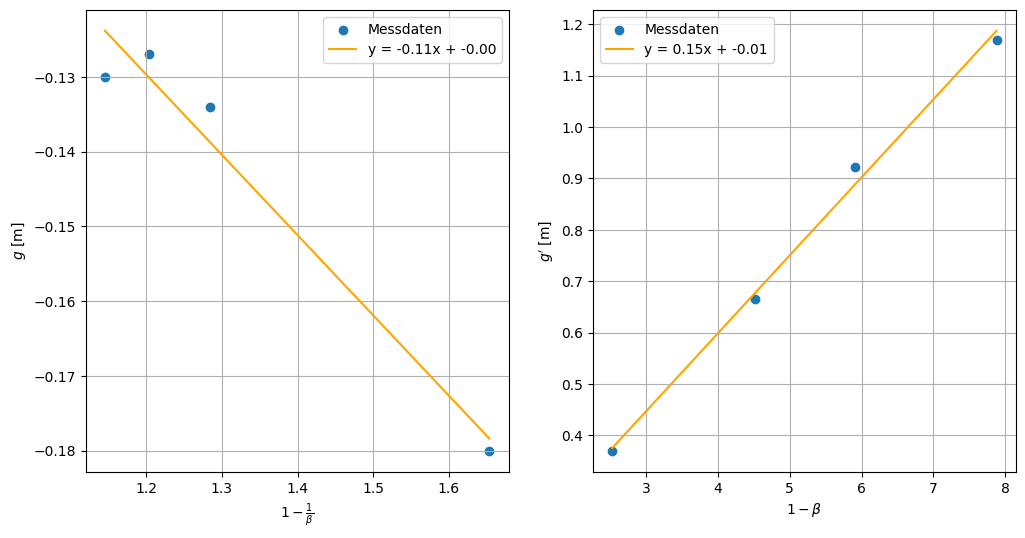

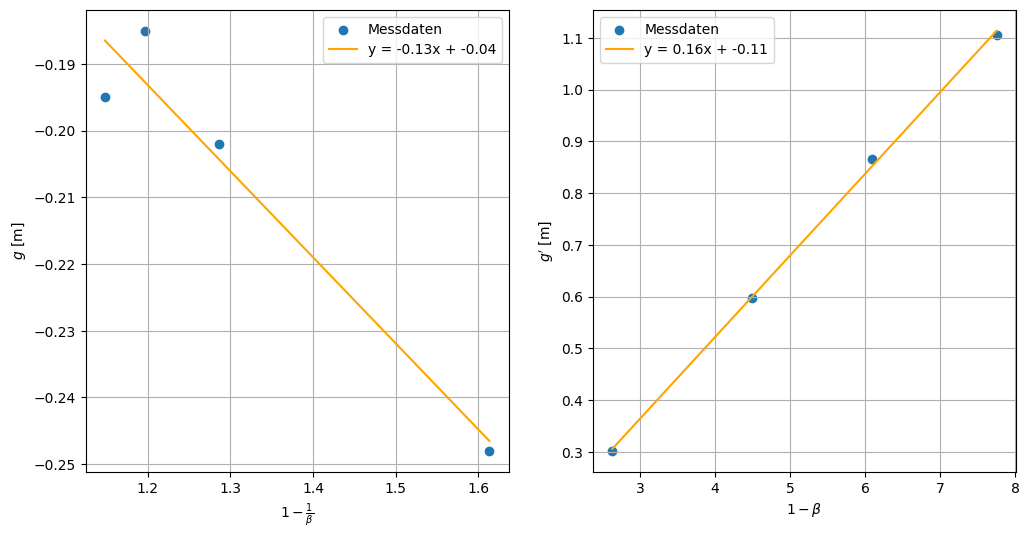

In [66]:
def linear(x, m, b):
    return m * x + b

brennweiten = []
u_brennweiten = []

h1s = []
u_h1s = []

h2s = []
u_h2s = []

for order, df in betas.items():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()

    popt, pcov = curve_fit(linear, df["1-1/beta"], df["g"])
    x = np.linspace(df["1-1/beta"].min(), df["1-1/beta"].max(), 100)
    y = linear(x, *popt)
    brennweiten.append(popt[0])
    u_brennweiten.append(np.sqrt(np.diag(pcov))[0])
    h1s.append(popt[1])
    u_h1s.append(np.sqrt(np.diag(pcov))[1])

    axs[0].scatter(x=df["1-1/beta"], y=df["g"], label="Messdaten")
    axs[0].grid()
    axs[0].set_xlabel(r"$1 - \frac{1}{\beta}$")
    axs[0].set_ylabel(r"$g$ [m]")
    axs[0].plot(x, y, label=f"y = {popt[0]:.2f}x + {popt[1]:.2f}", c="orange")
    axs[0].legend()

    popt, pcov = curve_fit(linear, df["1-beta"], df["g'"])
    x = np.linspace(df["1-beta"].min(), df["1-beta"].max(), 100)
    y = linear(x, *popt)
    h2s.append(popt[1])
    u_h2s.append(np.sqrt(np.diag(pcov))[1])

    axs[1].scatter(x=df["1-beta"], y=df["g'"], label="Messdaten")
    axs[1].grid()
    axs[1].set_xlabel(r"$1 - \beta$")
    axs[1].set_ylabel(r"$g'$ [m]")
    axs[1].plot(x, y, label=f"y = {popt[0]:.2f}x + {popt[1]:.2f}", c="orange")
    axs[1].legend()

    fig.savefig(f"Abbe_{order}.svg")

In [67]:
# Brennweiten
brennweite, u_brennweite = weighted_mean(np.array(brennweiten), np.array(u_brennweiten))
brennweite * 1e2, u_brennweite * 1e2

(np.float64(-11.388802011104698), np.float64(1.2695775581208433))

In [30]:
# Hauptebenenabstand
h = np.array(h1s) - np.array(h2s)
h[1] *= 0.1
u_h = np.sqrt(np.array(u_h1s)**2 + np.array(u_h2s)**2)

h, u_h = weighted_mean(h, u_h)
h * 1e2, u_h * 1e2

(np.float64(0.728361636171645), np.float64(2.774694180295871))

## Aufgabe 7 mit Abbe-Werten

In [31]:
f2p, u_f2p = fehler_gauss(
    f2p_formula,
    [fp_symbol, f1p_symbol, t_symbol],
    [np.abs(brennweite), brennweite_g, 3e-2],
    [u_brennweite, u_brennweite_g, 0.1e-2],
)
f2p * 1e2, u_f2p * 1e2

(np.float64(-12.235562914387648), np.float64(2.5650677783566027))

## Aufgabe 8 (Lage der Hauptebenen)

Hier muss man auf die Vorzeichen achten, bei beiden liegt Hauptebene links vom Linsensystem

Hauptebenenabstand ist laut Franz ca. 1.6 cm

In [32]:
t = 3e-2
delta = 3e-2 - brennweite_g + 100e-3

In [33]:
# z
z = (brennweite_g * t)/delta
z * 1e2

np.float64(3.896234217995503)

In [34]:
# zp
zp = (-100e-3 * t)/delta
zp * 1e2

np.float64(-5.304795552304233)

In [35]:
(z - np.abs(zp)) * 1e2

np.float64(-1.4085613343087298)

In [36]:
H = t**2 / delta
H * 1e2

np.float64(1.5914386656912698)

## Frage 4 Illustration

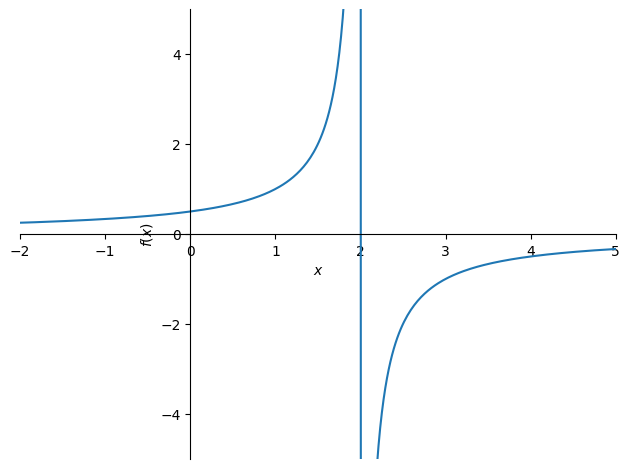

In [42]:
x = symbols("x")
f1 = 1
plot(-f1**2 / (x - 2*f1), xlim=(-2, 5), ylim=(-5, 5))